# Clustering analysis on 10k PBMC data

In [2]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

tf.enable_eager_execution()
tf.executing_eagerly()

True

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [5]:
# Network parameters
parameters = {
    'latent_dim': 100,
    'layers_enc_dim': [1000, 500, 400, 300, 200],
    'layers_dec_dim': [200, 300, 400, 500, 1000],
    'layers_dis_dim': [1000, 500, 400, 300, 200],
    'batch_size': 1000,
    'epochs': 30
}

In [6]:
model = AAE1(**parameters)

In [7]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [8]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,30,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,100,dimension of latent space Z
layer_1_enc_dim,1000,dimension of encoder dense layer 1


In [10]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 1000)         2146000     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 1000)         4000        H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 1000)         0           BN_1[0][0]                       
___________________________________________________________________________

In [ ]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [12]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 30/30, rec. loss: 0.785342, dis. loss: 0.207950


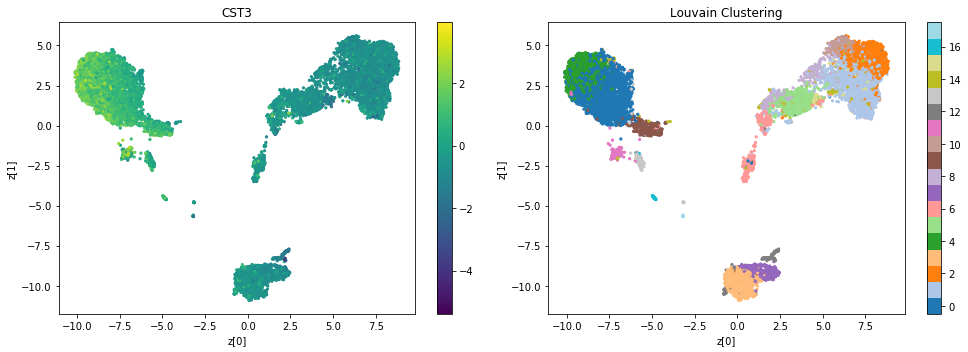

Training completed.
All networks exported in h5 format.


In [13]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

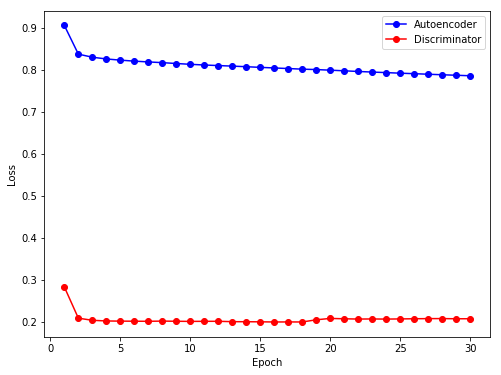

In [14]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

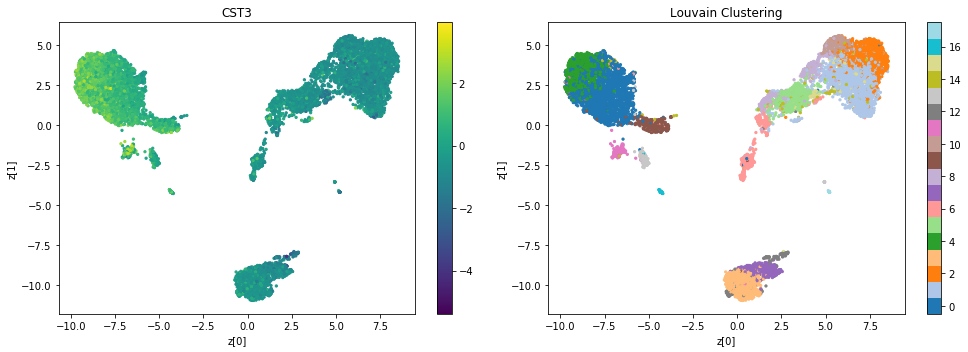

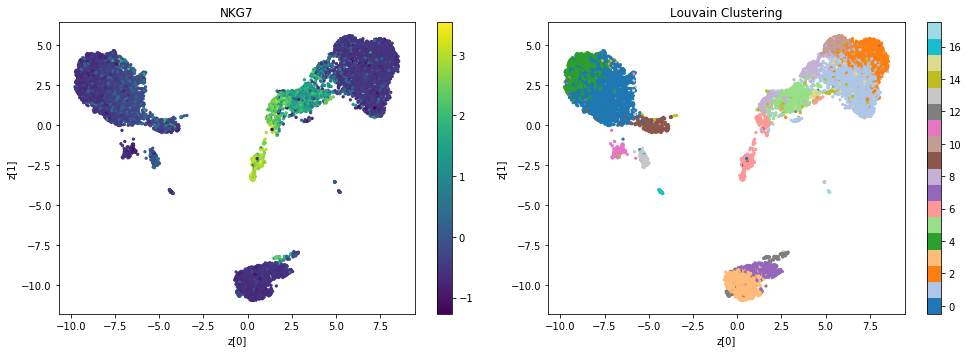

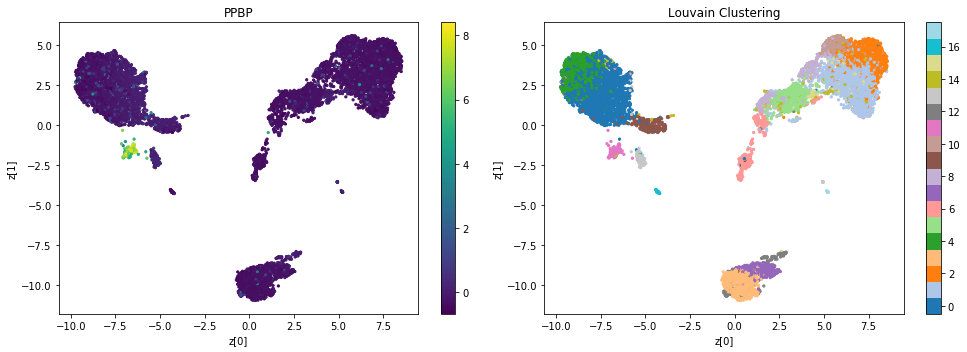

In [17]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE1/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

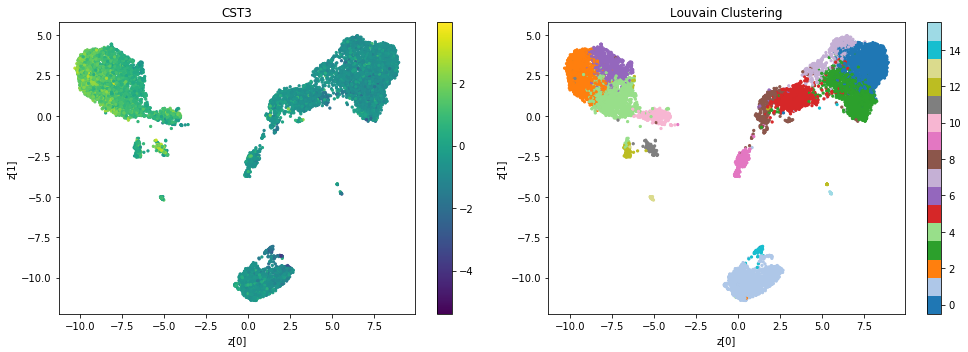

ARI = 0.5348543962395436
AMI = 0.7110114590220277


In [20]:
RES=1.0
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
RES=0.6
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 100,
    'layers_enc_dim': [1000, 500, 400, 300, 200],
    'layers_dec_dim': [200, 300, 400, 500, 1000],
    'batch_size': 1000,
    'epochs': 5000
}

In [ ]:
model = VAE(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [ ]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

In [ ]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
RES=0.6
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))